In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import sklearn.feature_selection
import torch

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

In [2]:
data = pd.read_csv('train.csv')

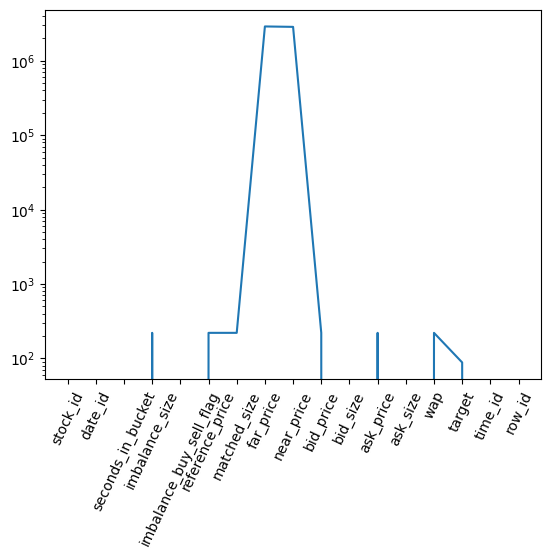

In [3]:
how_many_nas = []

for column in data.columns:
    how_many_nas.append(data[data[column].isna()].shape[0])

plt.plot(how_many_nas)
plt.xticks(np.arange(0, len(data.columns),1),data.columns, rotation=65)
plt.yscale('log')

In [4]:
data = data[data['wap'].notna()]

(0.0, 100.0)

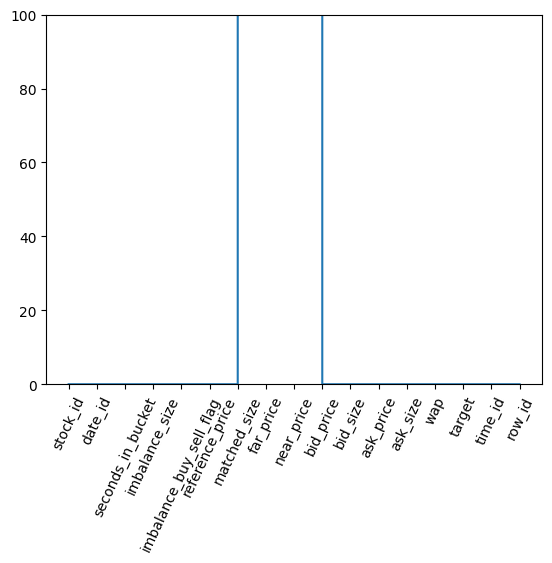

In [5]:
how_many_nas = []

for column in data.columns:
    how_many_nas.append(data[data[column].isna()].shape[0])

plt.plot(how_many_nas)
plt.xticks(np.arange(0, len(data.columns),1),data.columns, rotation=65)
plt.ylim(0,100)

In [6]:
data

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [7]:
train, val = data[data['date_id']<400], data[data['date_id']>=400]

In [8]:
train = train.drop(['row_id'], axis=1)


val = val.drop(['row_id'], axis=1)


In [9]:
quantitative_features = ['seconds_in_bucket', 
                         'imbalance_size', 
                         'imbalance_buy_sell_flag', 
                         'reference_price', 
                         'matched_size', 
                         'bid_price', 
                         'bid_size', 
                         'ask_price', 
                         'ask_size', 
                         'wap']

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf


In [11]:
autocorr_over_dates = {}
cint_over_dates = {}

for group_name, df_group in train.groupby(['date_id', 'stock_id']):
    autocorr_over_dates[group_name], cint_over_dates[group_name] = pacf(df_group['wap'], alpha=0.05)

In [12]:
stock_return_array = np.zeros((train['stock_id'].nunique(), train['date_id'].nunique(), train['seconds_in_bucket'].nunique()))
index_return_array = np.zeros((train['stock_id'].nunique(), train['date_id'].nunique(), train['seconds_in_bucket'].nunique()))



for group_name, df_group in train.groupby(['stock_id', 'date_id']):
    df_group['stock_return'] = (df_group['wap'].shift(-6)/df_group['wap'] - 1)*10000
    df_group['index_return'] = (df_group['stock_return'] - df_group['target'])
    stock_return_array[group_name[0], group_name[1]] = df_group['stock_return'].values
    index_return_array[group_name[0], group_name[1]] = df_group['index_return'].values
    

In [13]:
index_returns = np.asarray([np.mean(index_return_array[:,i,0], axis=0) for i in range(train['date_id'].nunique())])

In [14]:
stock_returns = stock_return_array[:,:,0]

In [15]:
stock_returns.shape

(200, 400)

In [16]:
index_returns.shape

(400,)

In [17]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(np.transpose(stock_returns), index_returns)

LinearRegression()

In [165]:
lr.score(np.transpose(stock_returns), index_returns)

0.9999999994109868

In [18]:
index_weights = lr.coef_

In [19]:
index_weights

array([0.00400125, 0.00099987, 0.00200128, 0.00599994, 0.00400121,
       0.00399956, 0.00200032, 0.00599966, 0.00599661, 0.00200492,
       0.00200645, 0.00799816, 0.00599922, 0.00200264, 0.00800124,
       0.00600087, 0.00199871, 0.00599952, 0.00400155, 0.00200465,
       0.0040001 , 0.00100092, 0.00600191, 0.00399988, 0.00200017,
       0.00199646, 0.00399953, 0.00199961, 0.00399943, 0.00399966,
       0.0010062 , 0.00100165, 0.00199363, 0.00200053, 0.00599833,
       0.00400155, 0.00399352, 0.00400203, 0.00600202, 0.00200426,
       0.00199672, 0.04000042, 0.00200007, 0.00200003, 0.003997  ,
       0.04000025, 0.00199916, 0.00099862, 0.0059979 , 0.00399326,
       0.00400274, 0.00599802, 0.00100409, 0.00399838, 0.00399882,
       0.00199872, 0.00600362, 0.00399724, 0.00599947, 0.00399687,
       0.00600278, 0.00399774, 0.00199998, 0.00099904, 0.00199902,
       0.0040049 , 0.00199985, 0.007996  , 0.00399891, 0.00400048,
       0.00199794, 0.00399912, 0.00600247, 0.00200521, 0.00400

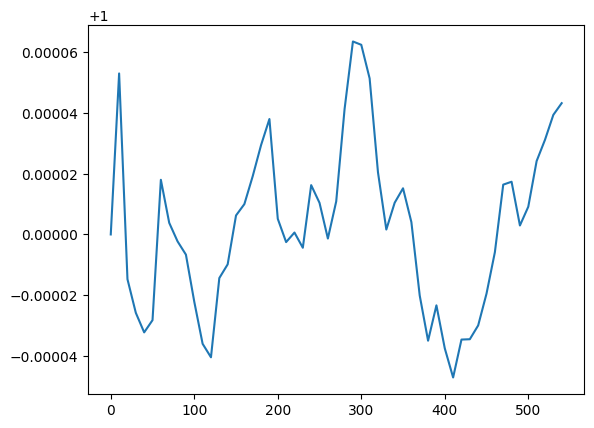

In [20]:
plt.plot(np.arange(0,550,10), train.groupby(['seconds_in_bucket']).mean()['wap'])

In [21]:
autocorr = np.zeros((len(autocorr_over_dates.keys()),18))

lower_range = np.zeros((len(autocorr_over_dates.keys()),18))
upper_range = np.zeros((len(autocorr_over_dates.keys()),18))

counter = 0
for index, key in enumerate(autocorr_over_dates.keys()):
    
    if not sum(abs(autocorr_over_dates[key])>1)>=1 and autocorr_over_dates[key].shape[0]==18: 
        counter+=1
        autocorr[index,:] = autocorr_over_dates[key]
        lower_range[index,:] = cint_over_dates[key][:,0]
        upper_range[index,:] = cint_over_dates[key][:,1]
    else:
        autocorr[index,:] = np.asarray(18*[np.nan])
        lower_range[index,:] = np.asarray(18*[np.nan])
        upper_range[index,:] = np.asarray(18*[np.nan])
        

#autocorr = np.nanmean(autocorr, axis=0)
#lower_range = np.nanmean(lower_range, axis=0)
#upper_range = np.nanmean(upper_range, axis=0)

                        
    

Text(0.5, 0, 'Lag')

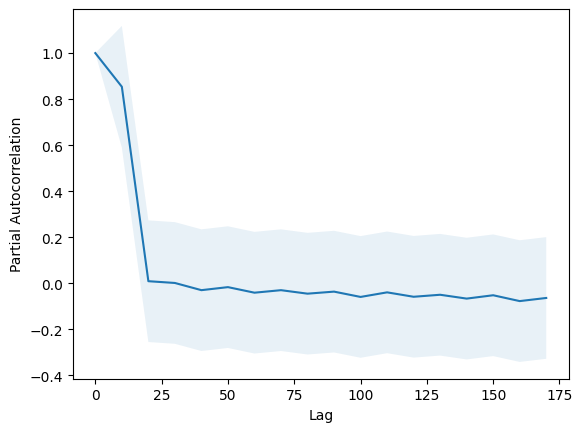

In [22]:
plt.plot(np.arange(0,180,10), np.nanmean(autocorr, axis=0) )
plt.fill_between(np.arange(0,180,10), 
                 np.nanmean(lower_range, axis=0) , 
                 np.nanmean(upper_range, axis=0) ,
                 alpha=0.1)


plt.ylabel('Partial Autocorrelation')
plt.xlabel('Lag')
#plt.ylim(-1,1)


In [23]:
for feature in quantitative_features:
    for i in range(1, 7):
        train['shifted by '+str(i) + " " + feature] = train.groupby(['date_id', 'stock_id'])[feature].shift(i)
        val['shifted by '+str(i) + " "+feature] = val.groupby(['date_id', 'stock_id'])[feature].shift(i)

In [24]:
train

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,shifted by 3 ask_size,shifted by 4 ask_size,shifted by 5 ask_size,shifted by 6 ask_size,shifted by 1 wap,shifted by 2 wap,shifted by 3 wap,shifted by 4 wap,shifted by 5 wap,shifted by 6 wap
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4346975,195,399,540,190803.52,1,0.998808,29276980.18,0.999258,0.998808,0.998695,...,106267.37,75432.64,152532.23,155669.40,0.998642,0.998629,0.998628,0.998746,0.998601,0.998858
4346976,196,399,540,596052.08,-1,1.000274,8865782.48,0.999756,0.999756,1.000274,...,71253.90,26500.18,85736.40,61444.42,1.000364,1.000351,1.000348,1.000691,1.000341,1.000361
4346977,197,399,540,1217799.96,1,1.000543,12264653.51,1.002325,1.001830,1.000444,...,71759.70,50631.06,38301.74,14148.40,1.000713,1.000834,1.000695,1.000570,1.000559,1.000603
4346978,198,399,540,0.00,0,1.003443,87357041.51,1.003443,1.003443,1.003166,...,624394.44,353044.44,296386.56,473501.47,1.003334,1.003322,1.003327,1.003343,1.003338,1.003064


In [48]:
train['new_target'] = train.groupby(['date_id', 'stock_id'])['wap'].shift(-6)
val['new_target'] = val.groupby(['date_id', 'stock_id'])['wap'].shift(-6)

In [26]:
quantitative_features

['seconds_in_bucket',
 'imbalance_size',
 'imbalance_buy_sell_flag',
 'reference_price',
 'matched_size',
 'bid_price',
 'bid_size',
 'ask_price',
 'ask_size',
 'wap']

In [27]:
train[quantitative_features]

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap
0,0,3180602.69,1,0.999812,13380276.64,0.999812,60651.50,1.000026,8493.03,1.000000
1,0,166603.91,-1,0.999896,1642214.25,0.999896,3233.04,1.000660,20605.09,1.000000
2,0,302879.87,-1,0.999561,1819368.03,0.999403,37956.00,1.000298,18995.00,1.000000
3,0,11917682.27,-1,1.000171,18389745.62,0.999999,2324.90,1.000214,479032.40,1.000000
4,0,447549.96,-1,0.999532,17860614.95,0.999394,16485.54,1.000016,434.10,1.000000
...,...,...,...,...,...,...,...,...,...,...
4346975,540,190803.52,1,0.998808,29276980.18,0.998695,237882.92,0.998808,197667.20,0.998756
4346976,540,596052.08,-1,1.000274,8865782.48,1.000274,67606.11,1.000533,187500.10,1.000343
4346977,540,1217799.96,1,1.000543,12264653.51,1.000444,78811.20,1.000543,40217.90,1.000509
4346978,540,0.00,0,1.003443,87357041.51,1.003166,1408242.78,1.003443,1191841.56,1.003316


In [28]:
training_features = quantitative_features.copy()
training_features.extend(['shifted by {} '.format(i)+feature for feature in quantitative_features for i in range(1,7)])

In [29]:
training_features_and_target = training_features + ['target']

In [30]:
train[training_features_and_target].dropna()

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,...,shifted by 4 ask_size,shifted by 5 ask_size,shifted by 6 ask_size,shifted by 1 wap,shifted by 2 wap,shifted by 3 wap,shifted by 4 wap,shifted by 5 wap,shifted by 6 wap,target
1146,60,1218204.43,1,1.000562,15342674.90,1.000455,14005.50,1.000562,10085.04,1.000517,...,12131.60,23519.16,8493.03,1.000434,1.000317,1.000085,0.999842,0.999892,1.000000,-0.200272
1147,60,175963.68,-1,1.000249,1634726.44,1.000249,170.22,1.000543,2383.78,1.000268,...,33717.42,33717.42,20605.09,1.000248,1.000248,1.000120,0.999973,0.999973,1.000000,-4.680157
1148,60,169954.53,-1,0.999824,1957040.69,0.999719,18984.00,1.000246,19183.94,0.999981,...,569.61,379.90,18995.00,1.000896,0.999397,0.999870,0.999857,1.000290,1.000000,9.080172
1149,60,11234625.94,-1,1.000257,19323658.92,1.000257,23255.00,1.000429,1395.54,1.000419,...,23252.00,12090.00,479032.40,1.000466,1.000334,1.000024,1.000064,0.999876,1.000000,-3.150106
1150,60,456231.82,-1,1.000085,17911982.63,1.000085,144.71,1.000292,31842.80,1.000086,...,36469.44,14476.00,434.10,1.000199,1.000043,1.000071,0.999895,1.000338,1.000000,-13.779998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4346975,540,190803.52,1,0.998808,29276980.18,0.998695,237882.92,0.998808,197667.20,0.998756,...,75432.64,152532.23,155669.40,0.998642,0.998629,0.998628,0.998746,0.998601,0.998858,-1.779795
4346976,540,596052.08,-1,1.000274,8865782.48,1.000274,67606.11,1.000533,187500.10,1.000343,...,26500.18,85736.40,61444.42,1.000364,1.000351,1.000348,1.000691,1.000341,1.000361,-7.029772
4346977,540,1217799.96,1,1.000543,12264653.51,1.000444,78811.20,1.000543,40217.90,1.000509,...,50631.06,38301.74,14148.40,1.000713,1.000834,1.000695,1.000570,1.000559,1.000603,5.110502
4346978,540,0.00,0,1.003443,87357041.51,1.003166,1408242.78,1.003443,1191841.56,1.003316,...,353044.44,296386.56,473501.47,1.003334,1.003322,1.003327,1.003343,1.003338,1.003064,2.870560


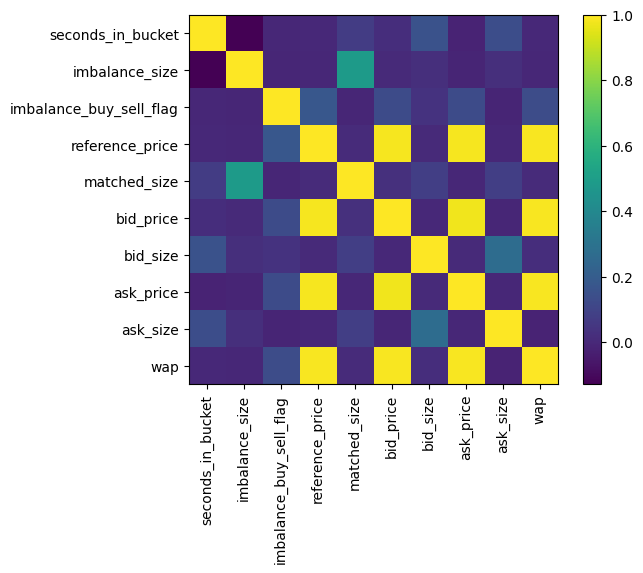

In [156]:
plt.imshow(train[quantitative_features].corr())
plt.xticks(np.arange(0,len(quantitative_features)), quantitative_features, rotation=90)
plt.yticks(np.arange(0,len(quantitative_features)), quantitative_features, rotation=0)
plt.colorbar()
plt.show()

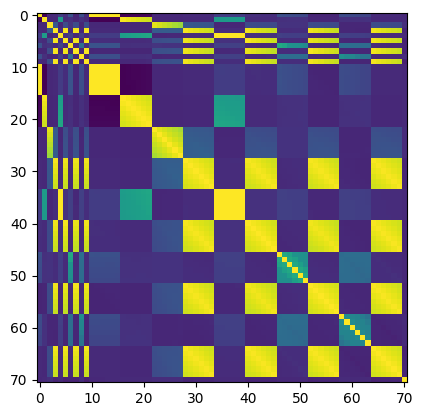

In [31]:
plt.imshow(train[training_features_and_target].corr())

In [32]:
print(training_features)
print(quantitative_features)

['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'shifted by 1 seconds_in_bucket', 'shifted by 2 seconds_in_bucket', 'shifted by 3 seconds_in_bucket', 'shifted by 4 seconds_in_bucket', 'shifted by 5 seconds_in_bucket', 'shifted by 6 seconds_in_bucket', 'shifted by 1 imbalance_size', 'shifted by 2 imbalance_size', 'shifted by 3 imbalance_size', 'shifted by 4 imbalance_size', 'shifted by 5 imbalance_size', 'shifted by 6 imbalance_size', 'shifted by 1 imbalance_buy_sell_flag', 'shifted by 2 imbalance_buy_sell_flag', 'shifted by 3 imbalance_buy_sell_flag', 'shifted by 4 imbalance_buy_sell_flag', 'shifted by 5 imbalance_buy_sell_flag', 'shifted by 6 imbalance_buy_sell_flag', 'shifted by 1 reference_price', 'shifted by 2 reference_price', 'shifted by 3 reference_price', 'shifted by 4 reference_price', 'shifted by 5 reference_price', 'shifted by 6 reference_price', 'shifted by 1 match

In [33]:
one_hot_stock_id = pd.get_dummies(train['stock_id'], dtype=float)

In [34]:
train_one_hot_stocks = train.join(one_hot_stock_id)

In [35]:
one_hot_stock_id = pd.get_dummies(val['stock_id'], dtype=float)
val_one_hot_stocks = val.join(one_hot_stock_id)

In [36]:
training_features_and_one_hot_and_target = training_features_and_target.copy()
training_features_and_one_hot_and_target.extend([i for i in range(200)])

training_features_and_one_hot = training_features.copy()
training_features_and_one_hot.extend([i for i in range(200)])

In [37]:
from tqdm import tqdm
train_scores = np.zeros(200)
train_maes = np.zeros(200)

val_scores = np.zeros(200)
val_maes = np.zeros(200)

n_training_points = np.zeros(200)

for i in tqdm(range(200)):
    xgb_r = xgb.XGBRegressor(n_estimators = 100, objective = 'reg:absoluteerror', eval_metric='mae')

    training_data_for_regressor = train[train['stock_id']==i][training_features_and_target].dropna()
    
    
    x_train = training_data_for_regressor[training_features]
    y_train = training_data_for_regressor['target']
    
    val_data_for_regressor = val[val['stock_id']==i][training_features_and_target].dropna()
    
    x_val = val_data_for_regressor[training_features]
    y_val = val_data_for_regressor['target']
    
    xgb_r.fit(x_train, y_train)

    train_scores[i] = xgb_r.score(x_train, y_train)
    train_maes[i] = 1/y_train.shape[0] * np.sum(abs(y_train - xgb_r.predict(x_train)))

    print(train_maes[i])
    
    val_scores[i] = xgb_r.score(x_val, y_val)
    val_maes[i] = 1/y_val.shape[0] * np.sum(abs(y_val - xgb_r.predict(x_val)))

    print(val_maes[i])
    
    n_training_points[i] = x_train.shape[0]
    

  0%|▊                                                                                                                                                                          | 1/200 [00:01<04:16,  1.29s/it]

3.131190515234256
4.101922864457986


  1%|█▋                                                                                                                                                                         | 2/200 [00:02<03:12,  1.03it/s]

6.034495200520874
8.431447153114519


  2%|██▌                                                                                                                                                                        | 3/200 [00:02<02:52,  1.14it/s]

5.089818559405802
8.066577683179343


  2%|███▍                                                                                                                                                                       | 4/200 [00:03<02:39,  1.23it/s]

2.707352679310443
3.546756551942961


  2%|████▎                                                                                                                                                                      | 5/200 [00:04<02:31,  1.28it/s]

3.2186425237609435
3.9524928820083325


  3%|█████▏                                                                                                                                                                     | 6/200 [00:05<02:35,  1.24it/s]

5.414877517176745
7.438375690315703


  4%|█████▉                                                                                                                                                                     | 7/200 [00:05<02:29,  1.29it/s]

4.5843482474741934
6.033814654555872


  4%|██████▊                                                                                                                                                                    | 8/200 [00:06<02:27,  1.31it/s]

4.469778642346322
5.754622844152425


  4%|███████▋                                                                                                                                                                   | 9/200 [00:07<02:24,  1.32it/s]

4.337704184206084
5.381247262255649


  5%|████████▌                                                                                                                                                                 | 10/200 [00:08<02:22,  1.33it/s]

3.3064349984335317
5.270888452891983


  6%|█████████▎                                                                                                                                                                | 11/200 [00:08<02:21,  1.34it/s]

3.1027671290672414
4.789603252817923


  6%|██████████▏                                                                                                                                                               | 12/200 [00:09<02:21,  1.33it/s]

8.042761700175028
9.95697072053189


  6%|███████████                                                                                                                                                               | 13/200 [00:10<02:22,  1.31it/s]

3.199940770685042
4.27491549078119


  7%|███████████▉                                                                                                                                                              | 14/200 [00:11<02:24,  1.29it/s]

4.428826507573834
5.238875017467418


  8%|████████████▊                                                                                                                                                             | 15/200 [00:12<02:37,  1.18it/s]

3.0715511874160173
4.638152529897158


  8%|█████████████▌                                                                                                                                                            | 16/200 [00:12<02:29,  1.23it/s]

4.200862928525815
5.548366905084852


  8%|██████████████▍                                                                                                                                                           | 17/200 [00:13<02:24,  1.26it/s]

4.2319533968285015
6.325294306654


  9%|███████████████▎                                                                                                                                                          | 18/200 [00:14<02:20,  1.30it/s]

4.511639871197298
5.954410450238745


 10%|████████████████▏                                                                                                                                                         | 19/200 [00:15<02:17,  1.32it/s]

6.342411678321017
8.300018928204471


 10%|█████████████████                                                                                                                                                         | 20/200 [00:15<02:14,  1.34it/s]

6.454889819667069
7.750468473322711


 10%|█████████████████▊                                                                                                                                                        | 21/200 [00:16<02:11,  1.36it/s]

3.9280851704010478
5.725499612209845


 11%|██████████████████▋                                                                                                                                                       | 22/200 [00:17<02:08,  1.39it/s]

3.2779097941023765
4.90768421281582


 12%|███████████████████▌                                                                                                                                                      | 23/200 [00:17<02:06,  1.40it/s]

4.765315241793074
6.616576622136092


 12%|████████████████████▍                                                                                                                                                     | 24/200 [00:18<02:06,  1.39it/s]

3.6140880224669947
5.0049254703833235


 12%|█████████████████████▎                                                                                                                                                    | 25/200 [00:19<02:05,  1.39it/s]

3.016761099636998
4.21667779034754


 13%|██████████████████████                                                                                                                                                    | 26/200 [00:20<02:04,  1.39it/s]

3.6831000287636377
5.091017275429284


 14%|██████████████████████▉                                                                                                                                                   | 27/200 [00:20<02:03,  1.40it/s]

3.3405157501292884
6.757890340350773


 14%|███████████████████████▊                                                                                                                                                  | 28/200 [00:21<02:02,  1.41it/s]

4.182765212051925
5.6609473642791


 14%|████████████████████████▋                                                                                                                                                 | 29/200 [00:22<02:01,  1.41it/s]

4.5987191028555765
5.169054762948797


 15%|█████████████████████████▌                                                                                                                                                | 30/200 [00:22<02:01,  1.39it/s]

3.751895432489352
4.876313357884966


 16%|██████████████████████████▎                                                                                                                                               | 31/200 [00:23<02:01,  1.39it/s]

3.617118462781455
4.677104110546294


 16%|███████████████████████████▏                                                                                                                                              | 32/200 [00:24<01:59,  1.40it/s]

7.464372464542069
22.85874568173022


 16%|████████████████████████████                                                                                                                                              | 33/200 [00:25<01:58,  1.41it/s]

3.222905144929375
4.490482205934872


 17%|████████████████████████████▉                                                                                                                                             | 34/200 [00:25<01:58,  1.40it/s]

5.228669520057494
8.243378543063796


 18%|█████████████████████████████▋                                                                                                                                            | 35/200 [00:26<01:58,  1.39it/s]

4.235746094673471
5.4862969358195635


 18%|██████████████████████████████▌                                                                                                                                           | 36/200 [00:27<01:58,  1.38it/s]

3.290925973683674
4.386236806312579


 18%|███████████████████████████████▍                                                                                                                                          | 37/200 [00:28<02:12,  1.23it/s]

3.993561021855996
5.6394045382633715


 19%|████████████████████████████████▎                                                                                                                                         | 38/200 [00:28<02:07,  1.27it/s]

2.700127608231736
3.962866314634043


 20%|█████████████████████████████████▏                                                                                                                                        | 39/200 [00:29<02:02,  1.31it/s]

3.7887245724899663
4.467289768018415


 20%|██████████████████████████████████                                                                                                                                        | 40/200 [00:30<02:00,  1.33it/s]

3.1384673800018015
4.380690683012498


 20%|██████████████████████████████████▊                                                                                                                                       | 41/200 [00:31<01:58,  1.34it/s]

4.966885839420433
6.4711207171246725


 21%|███████████████████████████████████▋                                                                                                                                      | 42/200 [00:31<01:56,  1.36it/s]

4.216740906078997
5.312153824225557


 22%|████████████████████████████████████▌                                                                                                                                     | 43/200 [00:32<01:56,  1.35it/s]

6.628978522557454
8.903369081768535


 22%|█████████████████████████████████████▍                                                                                                                                    | 44/200 [00:33<01:54,  1.37it/s]

3.832998610015366
6.150261864619083


 22%|██████████████████████████████████████▎                                                                                                                                   | 45/200 [00:34<01:54,  1.36it/s]

3.514430790818521
4.806374330517669


 23%|███████████████████████████████████████                                                                                                                                   | 46/200 [00:34<01:52,  1.36it/s]

2.5622494790147052
3.345533919768602


 24%|███████████████████████████████████████▉                                                                                                                                  | 47/200 [00:35<01:54,  1.34it/s]

4.721638430229473
5.767715940092167


 24%|████████████████████████████████████████▊                                                                                                                                 | 48/200 [00:36<01:53,  1.34it/s]

4.152579760550862
5.335729059566216


 24%|█████████████████████████████████████████▋                                                                                                                                | 49/200 [00:37<01:51,  1.36it/s]

3.8982309288612487
5.015110758571388


 25%|██████████████████████████████████████████▌                                                                                                                               | 50/200 [00:37<01:49,  1.37it/s]

3.208356518271837
7.100720826669881


 26%|███████████████████████████████████████████▎                                                                                                                              | 51/200 [00:38<01:49,  1.37it/s]

4.653309011150763
6.711209335121793


 26%|████████████████████████████████████████████▏                                                                                                                             | 52/200 [00:39<01:48,  1.37it/s]

6.061644064784441
7.469478136252772


 26%|█████████████████████████████████████████████                                                                                                                             | 53/200 [00:39<01:46,  1.38it/s]

3.6444303614867968
5.257530568114011


 27%|█████████████████████████████████████████████▉                                                                                                                            | 54/200 [00:40<01:44,  1.39it/s]

3.2337978295847702
4.167849510424913


 28%|██████████████████████████████████████████████▊                                                                                                                           | 55/200 [00:41<01:44,  1.39it/s]

3.368815810303872
5.060677976487309


 28%|███████████████████████████████████████████████▌                                                                                                                          | 56/200 [00:42<01:42,  1.40it/s]

2.888959122172382
3.8855858705132085


 28%|████████████████████████████████████████████████▍                                                                                                                         | 57/200 [00:42<01:43,  1.38it/s]

5.303743510793062
6.550404782459328


 29%|█████████████████████████████████████████████████▎                                                                                                                        | 58/200 [00:43<01:43,  1.37it/s]

4.102082529661049
5.490601653769512


 30%|██████████████████████████████████████████████████▏                                                                                                                       | 59/200 [00:44<01:44,  1.36it/s]

3.502376282677234
4.9739252644367316


 30%|███████████████████████████████████████████████████                                                                                                                       | 60/200 [00:45<01:43,  1.35it/s]

5.392116514436511
6.883001872287751


 30%|███████████████████████████████████████████████████▊                                                                                                                      | 61/200 [00:45<01:42,  1.36it/s]

4.861963000585731
5.326628894465875


 31%|████████████████████████████████████████████████████▋                                                                                                                     | 62/200 [00:46<01:40,  1.37it/s]

5.896625449240025
10.411635046589504


 32%|█████████████████████████████████████████████████████▌                                                                                                                    | 63/200 [00:47<01:40,  1.37it/s]

5.965971905899949
8.77115135664825


 32%|██████████████████████████████████████████████████████▍                                                                                                                   | 64/200 [00:47<01:38,  1.37it/s]

3.415511979943276
4.420549637025721


 32%|███████████████████████████████████████████████████████▎                                                                                                                  | 65/200 [00:48<01:39,  1.36it/s]

4.610732167696437
7.882776492815533


 33%|████████████████████████████████████████████████████████                                                                                                                  | 66/200 [00:49<01:38,  1.36it/s]

3.591235344306256
4.856628449559103


 34%|████████████████████████████████████████████████████████▉                                                                                                                 | 67/200 [00:50<01:37,  1.36it/s]

3.9741080974758303
5.548571669189837


 34%|█████████████████████████████████████████████████████████▊                                                                                                                | 68/200 [00:50<01:38,  1.34it/s]

5.431713798947409
5.588683754088013


 34%|██████████████████████████████████████████████████████████▋                                                                                                               | 69/200 [00:51<01:37,  1.35it/s]

2.740553174523657
4.473888954984259


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 70/200 [00:52<01:34,  1.38it/s]

6.119824685627036
8.657279003436587


 36%|████████████████████████████████████████████████████████████▎                                                                                                             | 71/200 [00:53<01:33,  1.37it/s]

7.856513803106172
11.094711319283016


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 72/200 [00:53<01:32,  1.38it/s]

4.352955443126709
5.804092914779381


 36%|██████████████████████████████████████████████████████████████                                                                                                            | 73/200 [00:54<01:31,  1.38it/s]

3.4214706032858695
4.569350379924214


 37%|██████████████████████████████████████████████████████████████▉                                                                                                           | 74/200 [00:55<01:31,  1.37it/s]

3.818739617021262
6.429137115015009


 38%|███████████████████████████████████████████████████████████████▊                                                                                                          | 75/200 [00:55<01:30,  1.37it/s]

4.740767291673824
6.016998839904174


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 76/200 [00:56<01:30,  1.37it/s]

3.2134835268935986
4.700241777107164


 38%|█████████████████████████████████████████████████████████████████▍                                                                                                        | 77/200 [00:57<01:30,  1.37it/s]

3.7528735674793237
5.63482128725396


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 78/200 [00:58<01:29,  1.36it/s]

3.8907852332913038
5.017565418527558


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                      | 79/200 [00:58<01:29,  1.35it/s]

6.790546362456391
7.406032233539226


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 80/200 [00:59<01:22,  1.46it/s]

5.059921101983979
8.97430171889397


 40%|████████████████████████████████████████████████████████████████████▊                                                                                                     | 81/200 [01:00<01:23,  1.42it/s]

7.559356761038412
8.506859646114302


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                    | 82/200 [01:00<01:24,  1.40it/s]

5.37044006951644
6.459738527092299


 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                   | 83/200 [01:01<01:22,  1.41it/s]

8.918469029349202
17.811892851815852


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                  | 84/200 [01:02<01:22,  1.40it/s]

3.132294939767071
5.803052454144956


 42%|████████████████████████████████████████████████████████████████████████▎                                                                                                 | 85/200 [01:03<01:23,  1.38it/s]

2.7875248893063787
4.046952091056034


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                 | 86/200 [01:03<01:23,  1.37it/s]

7.697278322651462
9.080350193915704


 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                                | 87/200 [01:04<01:25,  1.32it/s]

8.887724632952391
13.474916198561752


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                               | 88/200 [01:05<01:25,  1.30it/s]

5.309338399341873
7.752211982531693


 44%|███████████████████████████████████████████████████████████████████████████▋                                                                                              | 89/200 [01:06<01:25,  1.30it/s]

3.443968302083306
4.860754583560366


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                             | 90/200 [01:07<01:23,  1.32it/s]

5.247434638189062
7.339275563093413


 46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                            | 91/200 [01:07<01:22,  1.32it/s]

3.8230957113817055
5.090531528183385


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                           | 92/200 [01:08<01:22,  1.31it/s]

4.91409773060573
7.2852072162995505


 46%|███████████████████████████████████████████████████████████████████████████████                                                                                           | 93/200 [01:09<01:21,  1.31it/s]

8.556371209866418
11.027707182515394


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                          | 94/200 [01:10<01:20,  1.31it/s]

3.572323579523389
11.842259847502511


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 95/200 [01:10<01:19,  1.32it/s]

5.711765529486408
7.668756725311837


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 96/200 [01:11<01:18,  1.32it/s]

3.5649482555420833
5.540724705360307


 48%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 97/200 [01:12<01:18,  1.32it/s]

4.757785980634977
6.906466048904957


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 98/200 [01:13<01:17,  1.32it/s]

5.362007000200368
5.919144829463326


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 99/200 [01:13<01:15,  1.34it/s]

4.283904517282275
6.82158662817157


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 100/200 [01:14<01:13,  1.36it/s]

4.047840219095033
7.021381542991968


 50%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 101/200 [01:15<01:12,  1.36it/s]

8.171702683504511
11.529149294777495


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 102/200 [01:15<01:11,  1.36it/s]

6.396894204075845
9.690619643762302


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                  | 103/200 [01:16<01:01,  1.58it/s]

4.319875336661247
8.436823574411088


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 104/200 [01:17<01:03,  1.52it/s]

4.858533988514257
6.086908301333432


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 105/200 [01:17<01:03,  1.49it/s]

3.125298058100437
5.048494536974877


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 106/200 [01:18<01:05,  1.43it/s]

2.7799879264578595
3.4643237300173717


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 107/200 [01:19<01:06,  1.41it/s]

3.2755909956635887
4.187441082224727


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 108/200 [01:20<01:05,  1.39it/s]

6.079497008323576
7.4070223948494425


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 109/200 [01:20<01:06,  1.36it/s]

5.558351870373799
7.439231288809997


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 110/200 [01:21<01:05,  1.37it/s]

3.0234915811119225
4.231683969249415


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 111/200 [01:22<01:05,  1.35it/s]

3.262484317805729
4.574411121375205


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 112/200 [01:23<01:05,  1.34it/s]

5.635132940505614
8.638926467933654


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 113/200 [01:23<01:04,  1.34it/s]

2.5791100559127242
3.0132547366358886


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 114/200 [01:24<01:03,  1.35it/s]

3.8231192351504077
5.184793127712948


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 115/200 [01:25<01:03,  1.34it/s]

4.672359705507884
7.8714887020645685


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 116/200 [01:26<01:02,  1.34it/s]

4.26462776321014
6.822726793056403


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 117/200 [01:26<01:01,  1.34it/s]

3.3904438129931793
4.619580572341761


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 118/200 [01:27<01:01,  1.34it/s]

3.653266306850733
5.457431573572951


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 119/200 [01:28<01:00,  1.34it/s]

5.678781424000507
7.256190986269345


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 120/200 [01:29<01:00,  1.32it/s]

5.328810042504851
6.650925002071264


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 121/200 [01:29<00:59,  1.32it/s]

3.8347249380896082
5.112526435408263


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 122/200 [01:30<00:58,  1.34it/s]

3.4805154921439065
4.807090806391539


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 123/200 [01:31<00:57,  1.35it/s]

4.087397189994815
5.687514080897704


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 124/200 [01:32<00:56,  1.33it/s]

3.1755754478727325
4.348876831309525


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 125/200 [01:32<00:57,  1.31it/s]

5.494581516871456
7.434834018360712


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 126/200 [01:33<00:55,  1.32it/s]

5.619879350671228
7.466835729804625


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 127/200 [01:34<00:55,  1.32it/s]

3.673076390524138
5.061966076282386


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 128/200 [01:35<00:53,  1.33it/s]

6.272479714329011
8.721035520698496


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 129/200 [01:35<00:53,  1.34it/s]

3.8998396351259124
5.506167984276023


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 130/200 [01:36<00:52,  1.32it/s]

8.801670803188133
10.36570536179549


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 131/200 [01:37<00:52,  1.31it/s]

2.6276102808784536
3.4299403115347595


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 132/200 [01:38<00:51,  1.32it/s]

4.075649367295928
5.1438202317633905


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 133/200 [01:38<00:50,  1.32it/s]

3.7290938145734396
5.0200757659123


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 134/200 [01:39<00:50,  1.31it/s]

3.4417009238174967
4.087852211593413


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 135/200 [01:40<00:49,  1.32it/s]

4.461542914624509
6.876887624389208


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 136/200 [01:40<00:44,  1.45it/s]

5.745206476391844
7.9784067492102935


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 137/200 [01:41<00:44,  1.43it/s]

4.512635700185981
6.474088472377672


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 138/200 [01:42<00:44,  1.40it/s]

4.003248242160431
5.0726399368303


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 139/200 [01:43<00:43,  1.40it/s]

5.779335741058241
9.723566927520677


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 140/200 [01:43<00:44,  1.35it/s]

4.462479483062843
5.655100851698019


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 141/200 [01:44<00:43,  1.35it/s]

2.9964513218482316
4.30663582367903


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 142/200 [01:45<00:43,  1.33it/s]

3.779922178532814
4.854407400586991


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 143/200 [01:46<00:42,  1.34it/s]

3.532823800722561
5.311817084108377


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 144/200 [01:46<00:41,  1.34it/s]

5.684636660019492
7.307802995045802


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 145/200 [01:47<00:41,  1.34it/s]

3.240878103804336
4.276007917532288


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 146/200 [01:48<00:40,  1.34it/s]

4.349527039118569
6.218756688808042


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 147/200 [01:49<00:39,  1.34it/s]

4.639591140738063
6.121423229059716


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 148/200 [01:49<00:38,  1.35it/s]

5.0513454241885505
5.962239608902734


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 149/200 [01:50<00:38,  1.34it/s]

3.4425398216929914
4.354197511610211


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 150/200 [01:51<00:37,  1.33it/s]

3.0285154205027434
4.300752210450912


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 151/200 [01:52<00:36,  1.34it/s]

4.397019041871113
4.716127444525445


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 152/200 [01:52<00:35,  1.34it/s]

2.598921429038581
3.3533571580524586


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 153/200 [01:53<00:34,  1.34it/s]

4.337127659096988
6.1385622948528


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 154/200 [01:54<00:33,  1.38it/s]

6.844707633175737
7.649262886115948


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 155/200 [01:55<00:32,  1.37it/s]

3.541997110476321
5.592324151348559


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 156/200 [01:55<00:32,  1.35it/s]

5.725020736250434
6.0427359006015156


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 157/200 [01:56<00:31,  1.38it/s]

6.52303902647624
9.404503495776892


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 158/200 [01:57<00:31,  1.34it/s]

3.530883029749764
4.901779078795122


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 159/200 [01:58<00:30,  1.34it/s]

8.402291408627853
9.351253427962453


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 160/200 [01:58<00:30,  1.33it/s]

4.650854920850259
6.4431531637809165


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 161/200 [01:59<00:30,  1.29it/s]

2.7026530198834915
3.558418672400518


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 162/200 [02:00<00:29,  1.28it/s]

6.751067532150896
10.70464554954537


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 163/200 [02:01<00:29,  1.27it/s]

5.150218516267645
6.669763693915215


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 164/200 [02:01<00:28,  1.28it/s]

2.648017179952338
3.473914887711212


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 165/200 [02:02<00:27,  1.29it/s]

2.981830978657142
4.025946314150206


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 166/200 [02:03<00:26,  1.30it/s]

4.403940698396976
5.9042097779336515


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 167/200 [02:04<00:25,  1.32it/s]

3.346133937615986
4.408596101170365


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 168/200 [02:05<00:24,  1.31it/s]

3.7448120225573076
5.568569778071514


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 169/200 [02:05<00:23,  1.30it/s]

3.003449827133971
3.9145794422582902


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 170/200 [02:06<00:23,  1.30it/s]

3.3969321795201406
4.853402129262077


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 171/200 [02:07<00:22,  1.31it/s]

3.4274603898552636
4.629231372503789


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 172/200 [02:08<00:21,  1.33it/s]

3.457817646966284
4.728246558541044


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 173/200 [02:08<00:20,  1.33it/s]

7.160380255950598
8.227588736741655


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 174/200 [02:09<00:19,  1.32it/s]

5.047105686053888
7.179701299745578


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 175/200 [02:10<00:18,  1.32it/s]

8.981707601884235
10.674426247308096


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 176/200 [02:11<00:18,  1.32it/s]

2.8665921254282996
4.137286961356869


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 177/200 [02:11<00:17,  1.32it/s]

4.285060278115206
5.620720180020985


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 178/200 [02:12<00:16,  1.33it/s]

7.471922036977417
9.879943649360358


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 179/200 [02:13<00:16,  1.31it/s]

4.482914088195842
6.098125553045705


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 180/200 [02:14<00:15,  1.31it/s]

3.1395078969533787
4.863081805404384


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 181/200 [02:14<00:14,  1.31it/s]

7.295952185922321
9.845074050405163


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 182/200 [02:15<00:13,  1.32it/s]

3.969849848281489
5.528645034401956


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 183/200 [02:16<00:13,  1.28it/s]

3.8630640719894034
5.31239040709767


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 184/200 [02:17<00:12,  1.28it/s]

3.819586121749048
5.28128500020812


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 185/200 [02:18<00:11,  1.29it/s]

5.35873943250277
6.495688654815187


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 186/200 [02:18<00:10,  1.30it/s]

3.90097301564857
5.563661706761355


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 187/200 [02:19<00:09,  1.31it/s]

2.9938165061098423
4.230607624330305


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 188/200 [02:20<00:09,  1.32it/s]

3.186182363951597
3.863667886709205


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 189/200 [02:21<00:08,  1.33it/s]

6.104965536050915
8.824135964882636


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 190/200 [02:21<00:07,  1.33it/s]

3.6612620451631086
4.834742626876131


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 191/200 [02:22<00:06,  1.33it/s]

4.489680150391376
5.274494362612121


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 192/200 [02:23<00:06,  1.32it/s]

4.2887453873374755
5.643483746799577


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 193/200 [02:24<00:05,  1.34it/s]

3.6825689102171095
4.5069814924893965


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 194/200 [02:24<00:04,  1.33it/s]

3.2985607692281618
4.122665823516119


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 195/200 [02:25<00:03,  1.34it/s]

4.795041403049305
6.632144673659724


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 196/200 [02:26<00:03,  1.13it/s]

3.31621307765985
4.337124859277298


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 197/200 [02:27<00:02,  1.08it/s]

3.7982427720925345
5.160917533014913


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 198/200 [02:28<00:01,  1.13it/s]

4.391539641754703
6.456301679137455


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 199/200 [02:29<00:00,  1.18it/s]

3.154037901916872
3.910316779060019


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:29<00:00,  1.33it/s]

4.849068261863819
5.310604547218976


In [38]:
np.mean(val_maes)

6.241631339376122

(array([ 1.,  2.,  5.,  0.,  6.,  8., 12.,  8.,  8., 12., 15., 12., 12.,
        10.,  6.,  8.,  2.,  8.,  6.,  5.,  3.,  4.,  7.,  4.,  2.,  2.,
         3.,  3.,  3.,  3.,  2.,  1.,  1.,  2.,  3.,  0.,  0.,  2.,  2.,
         0.,  2.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 3.01325474,  3.21170965,  3.41016456,  3.60861946,  3.80707437,
         4.00552928,  4.20398419,  4.4024391 ,  4.60089401,  4.79934892,
         4.99780383,  5.19625874,  5.39471365,  5.59316856,  5.79162347,
         5.99007838,  6.18853329,  6.3869882 ,  6.58544311,  6.78389802,
         6.98235293,  7.18080784,  7.37926274,  7.57771765,  7.77617256,
         7.97462747,  8.17308238,  8.37153729,  8.5699922 ,  8.768447

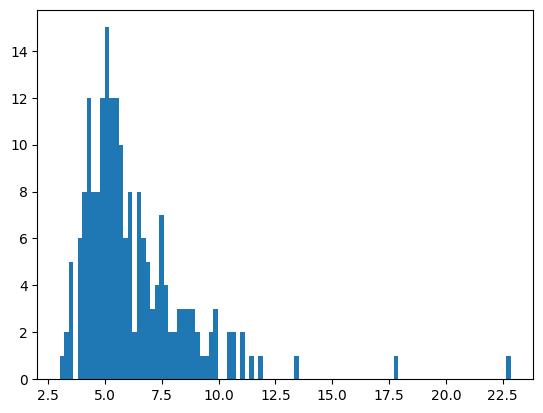

In [39]:
plt.hist(val_maes, bins=100)

In [40]:
training_data_for_regressor = train[training_features_and_target].dropna()

x_train = training_data_for_regressor[training_features]
y_train = training_data_for_regressor['target']

val_data_for_regressor = val[training_features_and_target].dropna()

x_val = val_data_for_regressor[training_features]
y_val = val_data_for_regressor['target']

xgb_r = xgb.XGBRegressor(n_estimators=100, objective = 'reg:absoluteerror', eval_metric='mae')

xgb_r.fit(x_train, y_train)

print(1/y_val.shape[0] * np.sum(abs(xgb_r.predict(x_val)-y_val)))

5.8810578809511185


In [41]:
xgb_r.score(x_val, y_val)

0.021098915726586953

In [45]:
training_features_and_new_target = training_features.copy()
training_features_and_new_target.append('new_target')

In [46]:
train[training_features_and_new_target]

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,...,shifted by 4 ask_size,shifted by 5 ask_size,shifted by 6 ask_size,shifted by 1 wap,shifted by 2 wap,shifted by 3 wap,shifted by 4 wap,shifted by 5 wap,shifted by 6 wap,new_target
0,0,3180602.69,1,0.999812,13380276.64,0.999812,60651.50,1.000026,8493.03,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000517
1,0,166603.91,-1,0.999896,1642214.25,0.999896,3233.04,1.000660,20605.09,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000268
2,0,302879.87,-1,0.999561,1819368.03,0.999403,37956.00,1.000298,18995.00,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999981
3,0,11917682.27,-1,1.000171,18389745.62,0.999999,2324.90,1.000214,479032.40,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000419
4,0,447549.96,-1,0.999532,17860614.95,0.999394,16485.54,1.000016,434.10,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4346975,540,190803.52,1,0.998808,29276980.18,0.998695,237882.92,0.998808,197667.20,0.998756,...,75432.64,152532.23,155669.40,0.998642,0.998629,0.998628,0.998746,0.998601,0.998858,NaN
4346976,540,596052.08,-1,1.000274,8865782.48,1.000274,67606.11,1.000533,187500.10,1.000343,...,26500.18,85736.40,61444.42,1.000364,1.000351,1.000348,1.000691,1.000341,1.000361,NaN
4346977,540,1217799.96,1,1.000543,12264653.51,1.000444,78811.20,1.000543,40217.90,1.000509,...,50631.06,38301.74,14148.40,1.000713,1.000834,1.000695,1.000570,1.000559,1.000603,NaN
4346978,540,0.00,0,1.003443,87357041.51,1.003166,1408242.78,1.003443,1191841.56,1.003316,...,353044.44,296386.56,473501.47,1.003334,1.003322,1.003327,1.003343,1.003338,1.003064,NaN


In [67]:
training_data_for_regressor = train[training_features_and_new_target].dropna()

x_train = training_data_for_regressor[training_features]
y_train = training_data_for_regressor['new_target']

val_data_for_regressor = val[training_features_and_new_target].dropna()

x_val = val_data_for_regressor[training_features]
y_val = val_data_for_regressor['new_target']

xgb_r = xgb.XGBRegressor(n_estimators=100, objective = 'reg:absoluteerror', eval_metric='mae')

xgb_r.fit(x_train, y_train)

xgb_r.score(x_val, y_val)

0.8017112509182048

In [57]:
training_data_for_regressor = train[training_features_and_new_target].dropna()

x_train = training_data_for_regressor[quantitative_features]
y_train = training_data_for_regressor['new_target']

val_data_for_regressor = val[training_features_and_new_target].dropna()

x_val = val_data_for_regressor[quantitative_features]
y_val = val_data_for_regressor['new_target']

xgb_r = xgb.XGBRegressor(n_estimators=100, objective = 'reg:absoluteerror', eval_metric='mae')

xgb_r.fit(x_train, y_train)

xgb_r.score(x_val, y_val)

0.7981203323137575

In [53]:
1/y_val.shape[0] * np.sum(np.abs(y_val - xgb_r.predict(x_val)))

0.0006878203298552714

In [66]:
1/y_val.shape[0] * np.sum(np.abs(y_val - xgb_r.predict(x_val)))

0.0006915224434106056

Text(0, 0.5, 'Predicted Weighted Average Price 60 seconds later')

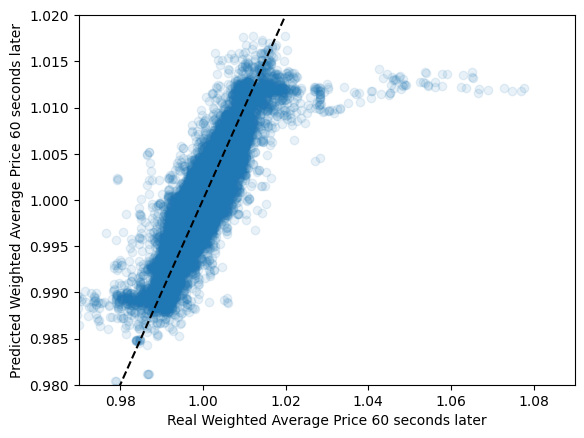

In [110]:
plt.scatter(y_val, xgb_r.predict(x_val), alpha=0.1)
plt.plot([-1,2],[-1,2], color='black', ls='--')
plt.xlim(0.97, 1.09)
plt.ylim(0.98,1.02)
plt.xlabel('Real Weighted Average Price 60 seconds later')
plt.ylabel('Predicted Weighted Average Price 60 seconds later')



array([2995203.83795282, 2995440.4684028 , 2995671.12619908,
       2995895.80995908, 2996114.51833596, 2996327.25001865,
       2996534.00373182, 2996734.77823594, 2996929.57232727,
       2997118.38483785, 2997301.21463558, 2997478.06062415,
       2997648.9217431 , 2997813.79696782, 2997972.68530957,
       2998125.58581545, 2998272.49756846, 2998413.41968749,
       2998548.35132732, 2998677.29167862, 2998800.239968  ,
       2998917.19545798, 2999028.15744699, 2999133.12526943,
       2999232.09829561, 2999325.07593181, 2999412.05762024,
       2999493.04283909, 2999568.03110251, 2999637.02196061,
       2999700.0149995 , 2999757.00984123, 2999808.00614387,
       2999853.00360144, 2999892.00194398, 2999925.00093749,
       2999952.000384  , 2999973.0001215 , 2999988.000024  ,
       2999997.0000015 , 3000000.        , 2999997.0000015 ,
       2999988.000024  , 2999973.0001215 , 2999952.000384  ,
       2999925.00093749, 2999892.00194398, 2999853.00360144,
       2999808.00614387,

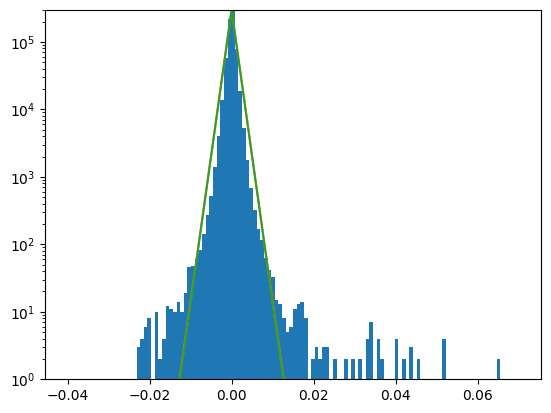

In [133]:
plt.hist(y_val - xgb_r.predict(x_val), bins=100)
plt.plot(np.arange(-0.04, 0.07, 0.001), 3*10**5./(np.abs(np.arange(-0.04, 0.07, 0.001))+1)**1000)
plt.plot(np.arange(-0.04, 0.07, 0.001), (3*10**5) * np.exp(-2000*np.abs((np.arange(-0.04, 0.07, 0.001)))**1/2))
plt.yscale('log')
plt.ylim(1,3*10**5)
plt.show()


In [139]:
{i: index_weights[i] for i in range(200)}

{0: 0.004001252261823492,
 1: 0.000999869175190654,
 2: 0.0020012819932469905,
 3: 0.005999935261675802,
 4: 0.004001208105052437,
 5: 0.003999555134614146,
 6: 0.002000324430919166,
 7: 0.005999662667473524,
 8: 0.005996606118004405,
 9: 0.002004920447880256,
 10: 0.0020064476141309386,
 11: 0.007998164431476096,
 12: 0.005999216034050195,
 13: 0.00200264275025638,
 14: 0.008001242315242164,
 15: 0.006000873939279027,
 16: 0.001998713748028848,
 17: 0.0059995226834829215,
 18: 0.004001548130448039,
 19: 0.002004652664218319,
 20: 0.004000104944161658,
 21: 0.0010009201684319851,
 22: 0.006001908839245625,
 23: 0.003999883662311207,
 24: 0.002000173103641867,
 25: 0.0019964554982992103,
 26: 0.0039995251495991615,
 27: 0.0019996092688061747,
 28: 0.003999433156988759,
 29: 0.003999655748029154,
 30: 0.0010061951341446907,
 31: 0.001001647368462494,
 32: 0.001993632433895559,
 33: 0.0020005310249815228,
 34: 0.005998332516130292,
 35: 0.004001546587966752,
 36: 0.003993515369070937,
 37

In [145]:
index_weights_df = pd.DataFrame.from_dict({'stock_id': [i for i in range(200)], 'weight': [index_weights[i] for i in range(200)]})

In [148]:
train_with_weights = pd.merge(train, index_weights_df, on='stock_id')
val_with_weights   = pd.merge(val,   index_weights_df, on='stock_id')


In [150]:
train_with_weights.groupby(['date_id', 'seconds_in_bucket'])

stock_id  imbalance_size  imbalance_buy_sell_flag  \
date_id seconds_in_bucket                                                       
0       0                  98.319372    7.625204e+06                 0.010471   
        10                 98.319372    7.036287e+06                 0.020942   
        20                 98.319372    7.008387e+06                 0.020942   
        30                 98.319372    6.992275e+06                 0.020942   
        40                 98.319372    6.914520e+06                 0.010471   
...                              ...             ...                      ...   
399     500                99.500000    9.387900e+05                -0.075000   
        510                99.500000    9.992969e+05                -0.105000   
        520                99.500000    8.869732e+05                -0.075000   
        530                99.500000    1.107431e+06                -0.025000   
        540                99.500000    9.559717e+05                -0.060000   

                           reference_price  matched_size  far_price  \
date_id seconds_in_bucket                                             
0       0                         0.999948  1.405229e+07        NaN   
        10                        1.000383  1.466877e+07        NaN   
        20                        1.000484  1.470110e+07        NaN   
        30                        1.000484  1.473673e+07        NaN   
        40                        1.000576  1.488845e+07        NaN   
...                                    ...           ...        ...   
399     500                       0.999394  4.216133e+07   0.999364   
        510                       0.999446  4.212837e+07   0.999397   
        520                       0.999459  4.226239e+07   0.999408   
        530                       0.999393  4.209498e+07   0.999376   
        540                       0.999422  4.219314e+07   0.999381   

                           near_price  bid_price       bid_size  ask_price  \
date_id seconds_in_bucket                                                    
0       0                         NaN   0.999624   31635.776230   1.000387   
        10                        NaN   1.000078   37714.930471   1.000690   
        20                        NaN   1.000203   34881.135131   1.000746   
        30                        NaN   1.000225   36319.106963   1.000764   
        40                        NaN   1.000320   35776.649005   1.000837   
...                               ...        ...            ...        ...   
399     500                  0.999357   0.999198   94637.530800   0.999622   
        510                  0.999396   0.999260  112529.572000   0.999679   
        520                  0.999411   0.999269  118905.643400   0.999683   
        530                  0.999368   0.999207  118962.934150   0.999627   
        540                  0.999399   0.999261  134854.975700   0.999665   

                           ...  shifted by 5 ask_size  shifted by 6 ask_size  \
date_id seconds_in_bucket  ...                                                 
0       0                  ...                    NaN                    NaN   
        10                 ...                    NaN                    NaN   
        20                 ...                    NaN                    NaN   
        30                 ...                    NaN                    NaN   
        40                 ...                    NaN                    NaN   
...                        ...                    ...                    ...   
399     500                ...            95152.30960            85843.70695   
        510                ...            97209.33315            95152.30960   
        520                ...            93297.16595            97209.33315   
        530                ...            85181.79105            93297.16595   
        540                ...           103008.71290            85181.7910

In [152]:
train_with_weights.groupby(['date_id', 'seconds_in_bucket'])

In [164]:
index_df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,shifted by 5 ask_size,shifted by 6 ask_size,shifted by 1 wap,shifted by 2 wap,shifted by 3 wap,shifted by 4 wap,shifted by 5 wap,shifted by 6 wap,new_target,weight
0,0.000000,0.000000,0.000000,13242.966087,0.004164,0.004163,55710.997900,NaN,NaN,0.004163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004166,0.000017
22000,0.001040,0.000000,0.000000,173.343788,-0.001040,0.001040,1708.649203,NaN,NaN,0.001040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001041,0.000001
44000,0.004165,0.000000,0.000000,630.751962,-0.002083,0.002082,3788.861753,NaN,NaN,0.002081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002082,0.000004
66000,0.018730,0.000000,0.000000,74407.768397,-0.006243,0.006245,114815.943400,NaN,NaN,0.006243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006246,0.000037
88000,0.016654,0.000000,0.000000,1863.427819,-0.004164,0.004162,74364.807831,NaN,NaN,0.004161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004164,0.000017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4159958,0.808744,0.164212,1.354748,8766.920512,-0.004105,0.004097,100405.132074,0.004015,0.004046,0.004097,...,42.994779,28.669344,0.004101,0.004101,0.004097,0.004099,0.004101,0.004103,0.004101,0.000016
4181958,1.218474,0.246156,2.030790,75550.521640,-0.006154,0.006165,792917.770519,0.006117,0.006126,0.006165,...,533.204144,1344.027825,0.006167,0.006166,0.006165,0.006160,0.006162,0.006163,0.006169,0.000037
4203738,0.319832,0.164017,1.353137,3383.284788,-0.004100,0.004133,10067.760456,0.003930,0.004073,0.004132,...,20.876195,18.312451,0.004132,0.004132,0.004127,0.004124,0.004133,0.004133,0.004139,0.000016
4223703,0.283113,0.164123,1.354018,5024.634745,0.004103,0.004107,9851.864378,0.004317,0.004146,0.004105,...,104.069843,147.870282,0.004111,0.004111,0.004111,0.004111,0.004111,0.004111,0.004112,0.000016


In [ ]:
index_df

In [64]:
training_data_for_regressor = train[training_features_and_new_target].dropna()

x_train = training_data_for_regressor[training_features]
y_train = training_data_for_regressor['new_target']

val_data_for_regressor = val[training_features_and_new_target].dropna()

x_val = val_data_for_regressor[training_features]
y_val = val_data_for_regressor['new_target']

xgb_r = xgb.XGBRegressor(n_estimators=100)

xgb_r.fit(x_train, y_train)

xgb_r.score(x_val, y_val)

0.8041702965324296

In [163]:
index_df = pd.DataFrame()

for group, df_group in train_with_weights.groupby(['date_id', 'seconds_in_bucket']):

    index_df_second = pd.DataFrame()
    
    for feature in df_group.columns:
        index_df_second[feature] = df_group[feature]*df_group['weight']/df_group['weight'].sum()
    index_df = pd.concat([index_df, index_df_second])

KeyboardInterrupt: 

In [56]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

training_data_for_regressor = train[training_features_and_new_target].dropna()

x_train = training_data_for_regressor[training_features]

ss = StandardScaler()
x_train = ss.fit_transform(x_train)
pca = PCA(n_components=10).fit(x_train)
x_train = pca.transform(x_train)

y_train = training_data_for_regressor['new_target']

val_data_for_regressor = val[training_features_and_new_target].dropna()

x_val = val_data_for_regressor[training_features]

x_val = ss.transform(x_val)
x_val = pca.transform(x_val)

y_val = val_data_for_regressor['new_target']

elastic_net = ElasticNet()

elastic_net.fit(x_train, y_train)

elastic_net.score(x_val, y_val)

-0.0010006739202852444

In [69]:
aggregate_train_mae = np.zeros(len(np.arange(10,300,10)))
aggregate_val_mae = np.zeros(len(np.arange(10,300,10)))
aggregate_train_score = np.zeros(len(np.arange(10,300,10)))
aggregate_val_score = np.zeros(len(np.arange(10,300,10)))

for index, n_estimators in enumerate(np.arange(10,300,10)):
    print(n_estimators)
    training_data_for_regressor = train[training_features_and_new_target].dropna()
    
    x_train = training_data_for_regressor[training_features]
    y_train = training_data_for_regressor['new_target']
    
    val_data_for_regressor = val[training_features_and_new_target].dropna()
    
    x_val = val_data_for_regressor[training_features]
    y_val = val_data_for_regressor['new_target']
    
    xgb_r = xgb.XGBRegressor(n_estimators=n_estimators, objective = 'reg:absoluteerror', eval_metric='mae')
    
    xgb_r.fit(x_train, y_train)
    
    aggregate_train_score[index] = xgb_r.score(x_train, y_train)
    aggregate_train_mae[index] = 1/y_train.shape[0] * np.sum(abs(xgb_r.predict(x_train)-y_train))

    aggregate_val_score[index] = xgb_r.score(x_val, y_val)
    aggregate_val_mae[index] = 1/y_val.shape[0] * np.sum(abs(xgb_r.predict(x_val)-y_val))


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300


IndexError: index 29 is out of bounds for axis 0 with size 29

Text(0, 0.5, 'validation MAE')

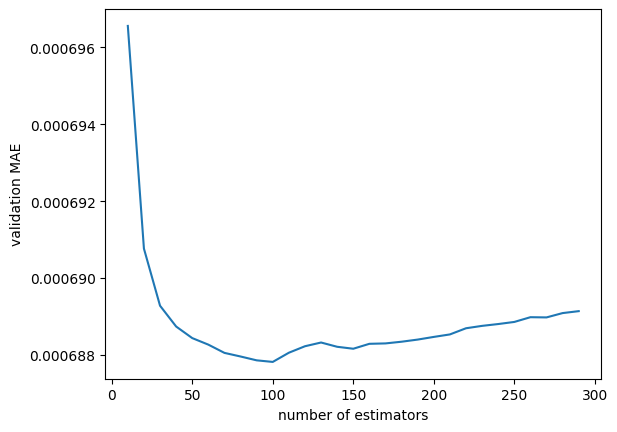

In [70]:
plt.plot(np.arange(10,300,10),aggregate_val_mae)
plt.xlabel('number of estimators')
plt.ylabel('validation MAE')

In [105]:
val_data_for_regressor['pred_target'] = xgb_r.predict(x_val)

val =  val.drop('pred_target', axis=1).join(val_data_for_regressor['pred_target'])

In [106]:
val_data_for_regressor

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,...,shifted imbalance_buy_sell_flag,shifted reference_price,shifted matched_size,shifted bid_price,shifted bid_size,shifted ask_price,shifted ask_size,shifted wap,target,pred_target
4347180,10,13954673.49,1,0.999745,10022665.17,0.999454,6289.10,0.999842,12376.80,0.999585,...,1.0,0.999454,10020705.20,0.999648,10312.00,1.000521,15275.08,1.000000,7.369518,0.050032
4347181,10,1943814.00,1,0.999648,1598872.27,0.998651,28777.32,1.002580,68892.85,0.999812,...,1.0,0.998651,1539364.28,0.998065,25527.00,1.002580,34190.00,1.000000,-9.819865,-2.313661
4347182,10,1874459.28,-1,1.000515,5132632.91,1.000199,443.80,1.001236,179925.30,1.000202,...,-1.0,1.000470,5088261.76,0.999974,3771.45,1.001236,179925.30,1.000000,6.860495,3.196700
4347183,10,5666369.17,1,0.999964,33362295.73,0.999759,13489.50,1.000066,2542.28,1.000017,...,1.0,1.000143,32587929.09,0.999964,9777.00,1.000731,196081.38,1.000000,4.810095,-2.222124
4347184,10,5050121.23,1,0.999716,7511554.03,0.999313,8674.50,0.999774,25861.93,0.999429,...,1.0,0.999428,7007913.42,0.999255,26022.00,1.000119,4167.12,1.000000,10.750294,0.968054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,540,2440722.89,-1,1.000317,28280361.74,1.000317,32257.04,1.000434,319862.40,1.000328,...,-1.0,1.000317,28280361.74,1.000317,68460.42,1.000434,123895.20,1.000359,2.310276,-2.141646
5237976,540,349510.47,-1,1.000643,9187699.11,1.000643,205108.40,1.000900,93393.07,1.000819,...,-1.0,1.000643,9187699.11,1.000643,199192.56,1.000900,100127.96,1.000814,-8.220077,-2.797674
5237977,540,0.00,0,0.995789,12725436.10,0.995789,16790.66,0.995883,180038.32,0.995797,...,-1.0,0.995976,12697368.89,0.995883,99371.80,0.996070,79937.60,0.995986,1.169443,-0.054120
5237978,540,1000898.84,1,0.999210,94773271.05,0.998970,125631.72,0.999210,669893.00,0.999008,...,1.0,0.999210,94773271.05,0.998970,143970.30,0.999210,447868.00,0.999028,-1.540184,1.597813


In [107]:
full_model_val_score = np.zeros(200)
for stock_id in range(200):
    full_model_val_score[stock_id] = 1./val[val['stock_id']==stock_id].shape[0] * np.sum(np.abs(val[val['stock_id']==stock_id]['target'] - val[val['stock_id']==stock_id]['pred_target']))

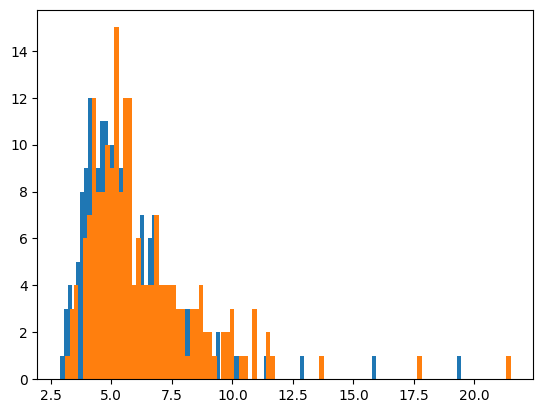

In [108]:
plt.hist(full_model_val_score, bins=100)
plt.hist(val_maes, bins=100)
plt.show()

In [118]:
xgb_r = xgb.XGBRegressor(objective = 'reg:absoluteerror', eval_metric='mae')

training_data_for_regressor = train_one_hot_stocks[training_features_and_one_hot_and_target].dropna()


x_train = training_data_for_regressor[training_features_and_one_hot]
y_train = training_data_for_regressor['target']

val_data_for_regressor = val_one_hot_stocks[training_features_and_one_hot_and_target].dropna()

x_val = val_data_for_regressor[training_features_and_one_hot]
y_val = val_data_for_regressor['target']

xgb_r.fit(x_train, y_train)

xgb_r.score(x_val, y_val)



0.020774118063632163

In [109]:
xgb_r = xgb.XGBRegressor(objective = 'reg:absoluteerror', eval_metric='mae')

training_data_for_regressor = train[training_features_and_target].dropna()


x_train = training_data_for_regressor[quantitative_features]
y_train = training_data_for_regressor['target']

val_data_for_regressor = val[training_features_and_target].dropna()

x_val = val_data_for_regressor[quantitative_features]
y_val = val_data_for_regressor['target']

xgb_r.fit(x_train, y_train)

xgb_r.score(x_val, y_val)

0.018019168984681033

In [110]:
np.sum(np.abs(y_val - xgb_r.predict(x_val)))/y_val.shape[0]

5.899091318677824

In [34]:
from sklearn.linear_model import ElasticNet

regressor = ElasticNet(max_iter=1000)

training_data_for_regressor = train[training_features_and_target].dropna()

x_train = training_data_for_regressor[training_features]
y_train = training_data_for_regressor['target']

val_data_for_regressor = val[training_features_and_target].dropna()

x_val = val_data_for_regressor[training_features]
y_val = val_data_for_regressor['target']



regressor.fit(x_train, y_train)
regressor.score(x_val, y_val)

/Users/hiroku007/miniforge3/envs/optiver/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.928e+08, tolerance: 3.860e+04
  model = cd_fast.enet_coordinate_descent(


0.0006964054318727708

In [35]:
np.sum(np.abs(y_val - regressor.predict(x_val)))/y_val.shape[0]

5.968282505504349

In [ ]:
class nn_model(torch.nn.Module):
    def __init__(self,
                 model,
                 loss_function,
                )

In [34]:
training_features

['seconds_in_bucket',
 'imbalance_size',
 'imbalance_buy_sell_flag',
 'reference_price',
 'matched_size',
 'bid_price',
 'bid_size',
 'ask_price',
 'ask_size',
 'wap',
 'shifted seconds_in_bucket',
 'shifted imbalance_size',
 'shifted imbalance_buy_sell_flag',
 'shifted reference_price',
 'shifted matched_size',
 'shifted bid_price',
 'shifted bid_size',
 'shifted ask_price',
 'shifted ask_size',
 'shifted wap']

In [ ]:
plt.show()

In [26]:
y = data['target']

In [29]:
data

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [34]:
data = data.drop(['target', 'row_id', 'time_id'], axis=1)

In [36]:
data.dtypes

stock_id                     int64
date_id                      int64
seconds_in_bucket            int64
imbalance_size             float64
imbalance_buy_sell_flag      int64
reference_price            float64
matched_size               float64
far_price                  float64
near_price                 float64
bid_price                  float64
bid_size                   float64
ask_price                  float64
ask_size                   float64
wap                        float64
time_id                      int64
dtype: object

In [4]:
stock_id_of_interest = 0
stock_mask = data['stock_id']==stock_id_of_interest
quantitative_features = ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'target']

In [5]:
vals, vecs = np.linalg.eig(data[quantitative_features].corr())

In [6]:
vals.shape

(13,)

In [7]:
randomized_data = data.copy()

In [18]:
torch.nn.functional.one_hot(torch.tensor(data['stock_id']))

torch.Size([5237980, 200])

In [14]:
data[(data['date_id']==0) & (data['stock_id']==0)]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
191,0,0,10,1299772.70,1,1.000026,15261106.63,NaN,NaN,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1,0_10_0
382,0,0,20,1299772.70,1,0.999919,15261106.63,NaN,NaN,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2,0_20_0
573,0,0,30,1299772.70,1,1.000133,15261106.63,NaN,NaN,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3,0_30_0
764,0,0,40,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4,0_40_0
955,0,0,50,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000348,42012.00,1.000455,9897.22,1.000434,0.599623,5,0_50_0
1146,0,0,60,1218204.43,1,1.000562,15342674.90,NaN,NaN,1.000455,14005.50,1.000562,10085.04,1.000517,-0.200272,6,0_60_0
1337,0,0,70,1264494.89,1,1.000455,15352380.96,NaN,NaN,1.000348,37904.16,1.000455,17366.82,1.000421,2.410412,7,0_70_0
1528,0,0,80,1189832.86,1,1.000241,15427043.00,NaN,NaN,1.000133,9427.34,1.000241,61984.40,1.000148,-0.389814,8,0_80_0
1719,0,0,90,1189272.89,1,1.000562,15427602.97,NaN,NaN,1.000348,23340.00,1.000562,40433.54,1.000426,-4.339814,9,0_90_0


In [56]:
data[quantitative_features].corr()

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
seconds_in_bucket,1.000000,-0.123946,-0.003635,-0.000835,0.068625,-0.000550,0.017627,0.014819,0.162867,-0.017826,0.146338,-0.001259,-0.002203
imbalance_size,-0.123946,1.000000,-0.010159,-0.003717,0.512367,0.000523,-0.030932,0.005691,0.021141,-0.012774,0.022623,-0.003495,-0.001190
imbalance_buy_sell_flag,-0.003635,-0.010159,1.000000,0.182100,-0.006003,0.018010,0.508853,0.129579,0.035238,0.132520,-0.013352,0.133823,0.015102
reference_price,-0.000835,-0.003717,0.182100,1.000000,0.007724,0.015349,0.473595,0.983646,0.007271,0.985068,-0.006528,0.988113,-0.017394
matched_size,0.068625,0.512367,-0.006003,0.007724,1.000000,-0.000705,-0.002722,0.023564,0.078554,-0.007270,0.079209,0.008281,0.000197
far_price,-0.000550,0.000523,0.018010,0.015349,-0.000705,1.000000,0.031519,0.014327,0.002229,0.014671,-0.000153,0.014643,-0.001804
near_price,0.017627,-0.030932,0.508853,0.473595,-0.002722,0.031519,1.000000,0.458373,0.032190,0.460380,-0.013298,0.462579,0.006045
bid_price,0.014819,0.005691,0.129579,0.983646,0.023564,0.014327,0.458373,1.000000,-0.001098,0.972906,-0.008456,0.989277,-0.022326
bid_size,0.162867,0.021141,0.035238,0.007271,0.078554,0.002229,0.032190,-0.001098,1.000000,0.006514,0.278326,0.018074,-0.018000
ask_price,-0.017826,-0.012774,0.132520,0.985068,-0.007270,0.014671,0.460380,0.972906,0.006514,1.000000,-0.002903,0.988907,-0.021674


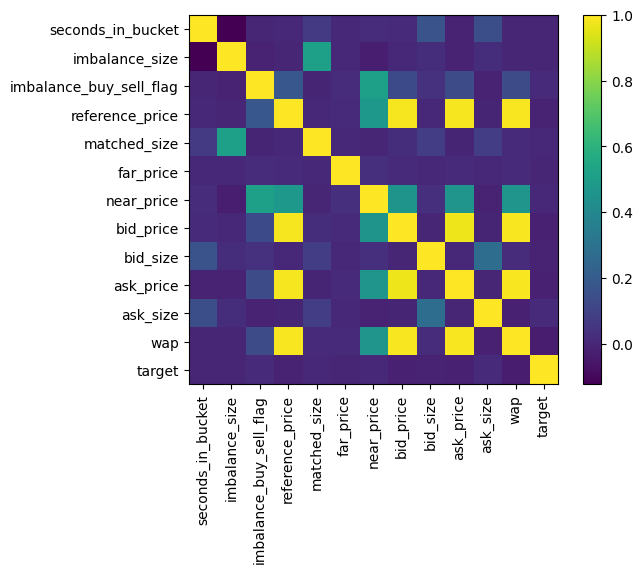

In [20]:
plt.imshow(data[quantitative_features].corr())
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12],quantitative_features)
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12],quantitative_features)
plt.tick_params(axis='x', rotation=90)

plt.colorbar()


In [25]:
data[quantitative_features].groupby(['date_id', 'stock_id']).mean()

KeyError: 'date_id'

In [74]:
data[quantitative_features].corr()

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
seconds_in_bucket,1.000000,-0.123946,-0.003635,-0.000835,0.068625,-0.000550,0.017627,0.014819,0.162867,-0.017826,0.146338,-0.001259,-0.002203
imbalance_size,-0.123946,1.000000,-0.010159,-0.003717,0.512367,0.000523,-0.030932,0.005691,0.021141,-0.012774,0.022623,-0.003495,-0.001190
imbalance_buy_sell_flag,-0.003635,-0.010159,1.000000,0.182100,-0.006003,0.018010,0.508853,0.129579,0.035238,0.132520,-0.013352,0.133823,0.015102
reference_price,-0.000835,-0.003717,0.182100,1.000000,0.007724,0.015349,0.473595,0.983646,0.007271,0.985068,-0.006528,0.988113,-0.017394
matched_size,0.068625,0.512367,-0.006003,0.007724,1.000000,-0.000705,-0.002722,0.023564,0.078554,-0.007270,0.079209,0.008281,0.000197
far_price,-0.000550,0.000523,0.018010,0.015349,-0.000705,1.000000,0.031519,0.014327,0.002229,0.014671,-0.000153,0.014643,-0.001804
near_price,0.017627,-0.030932,0.508853,0.473595,-0.002722,0.031519,1.000000,0.458373,0.032190,0.460380,-0.013298,0.462579,0.006045
bid_price,0.014819,0.005691,0.129579,0.983646,0.023564,0.014327,0.458373,1.000000,-0.001098,0.972906,-0.008456,0.989277,-0.022326
bid_size,0.162867,0.021141,0.035238,0.007271,0.078554,0.002229,0.032190,-0.001098,1.000000,0.006514,0.278326,0.018074,-0.018000
ask_price,-0.017826,-0.012774,0.132520,0.985068,-0.007270,0.014671,0.460380,0.972906,0.006514,1.000000,-0.002903,0.988907,-0.021674


In [57]:
train, val = data[data['time_id']<20000], data[data['time_id']>=20000]

In [76]:
train

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5730,0,0,300,0.00,0,1.000241,2.667012e+07,1.000241,1.000241,1.000026,19319.31,1.000241,16149.55,1.000143,-10.039806,30,0_300_0
5731,1,0,300,242332.96,-1,1.000073,3.242054e+06,0.981974,0.994490,0.999544,43205.40,1.000308,2042.76,1.000273,-1.329780,30,0_300_1
5732,2,0,300,0.00,0,1.000193,4.671376e+06,1.000193,1.000193,0.999035,18971.00,1.001036,59688.26,0.999518,14.009476,30,0_300_2
5733,3,0,300,2914730.16,1,0.999870,4.105778e+07,1.003870,1.002279,0.999827,25569.50,1.000042,37897.50,0.999914,-4.339814,30,0_300_3
5734,4,0,300,3396923.02,1,0.998496,3.835617e+07,1.007894,1.007894,0.998357,14446.00,0.998703,2601.18,0.998650,10.850430,30,0_300_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3946975,195,363,340,250424.28,-1,1.000208,3.532792e+07,0.998130,0.999896,1.000208,109011.60,1.000312,1540.96,1.000310,1.070499,19999,363_340_195
3946976,196,363,340,0.00,0,1.001763,7.051453e+06,1.001763,1.001763,1.001763,31608.00,1.002041,92221.61,1.001834,8.859634,19999,363_340_196
3946977,197,363,340,308126.77,-1,0.999930,1.389082e+07,0.996550,0.998240,0.999930,10560.06,1.000268,976.47,1.000240,-0.410080,19999,363_340_197
3946978,198,363,340,3662001.25,1,1.002570,1.017081e+08,1.007750,1.004124,1.002311,605732.40,1.002570,190453.20,1.002508,-0.110269,19999,363_340_198


In [82]:
data.select_dtypes(np.float64)

,imbalance_size,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,3180602.69,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704
1,166603.91,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986
2,302879.87,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950
3,11917682.27,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200
4,447549.96,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849
...,...,...,...,...,...,...,...,...,...,...,...
5237975,2440722.89,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276
5237976,349510.47,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077
5237977,0.00,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443
5237978,1000898.84,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184


In [ ]:
data.get_dummies(['stock_id']

In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier


In [72]:
feature_fitter = RandomForestClassifier()

In [75]:
train = train.dropna()
val = val.dropna()
feature_fitter.fit(np.asarray(train['reference_price']).reshape(-1,1), train['imbalance_buy_sell_flag'])
print(feature_fitter.score(np.asarray(train['reference_price']).reshape(-1,1), train['imbalance_buy_sell_flag']))
print(feature_fitter.score(np.asarray(val['reference_price']).reshape(-1,1), val['imbalance_buy_sell_flag']))



0.4403989476060761
0.4159142561983471


In [64]:
quantitative_features

['seconds_in_bucket',
 'imbalance_size',
 'imbalance_buy_sell_flag',
 'reference_price',
 'matched_size',
 'far_price',
 'near_price',
 'bid_price',
 'bid_size',
 'ask_price',
 'ask_size',
 'wap',
 'target']

In [45]:
r = 10
shuffled_vals = np.zeros((r, vals.shape[0]))

for i in range(r):
    print(r)
    data_randomized = data.copy()
    for col in quantitative_features:
        data_randomized[col] = data_randomized[col].sample(frac=1).reset_index(drop=True)

    
    shuffled_vals[i,:], _ = np.linalg.eig(data_randomized[quantitative_features].corr())

10
10
10
10
10
10
10
10
10
10


In [47]:
shuffled_vals

array([[1.0029332 , 1.00241727, 0.99755086, 0.99783582, 0.99815617,
        1.00148649, 1.0009563 , 1.00074977, 0.998907  , 0.99917839,
        1.00026315, 0.99990417, 0.9996614 ],
       [0.99639498, 0.99771467, 0.99805721, 0.99888169, 0.99917506,
        0.99964757, 1.00236251, 1.00018835, 1.00065195, 1.0019504 ,
        1.00186087, 1.00160796, 1.00150675],
       [1.00410946, 1.00320029, 1.00216228, 0.99691545, 1.00140611,
        1.00053562, 0.99999925, 1.00033871, 0.99760641, 0.9989394 ,
        0.99863869, 0.99799042, 0.9981579 ],
       [0.99704658, 1.00281073, 0.99779732, 0.99847707, 0.99900121,
        1.00174866, 1.00137988, 1.00127366, 1.00068776, 1.00040302,
        1.00004883, 0.99959792, 0.99972738],
       [0.99790695, 0.99799447, 0.99827484, 1.00225385, 1.00181034,
        1.00160043, 0.99891523, 0.99918281, 1.00110897, 0.99979838,
        1.00005552, 1.00063077, 1.00046744],
       [1.00285368, 0.99734053, 0.99787502, 0.9983524 , 1.00186383,
        1.00166932, 1.00127

In [48]:
from sklearn.ensemble import RandomForestRegressor


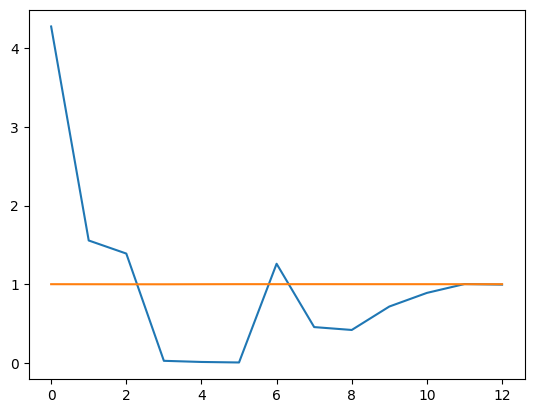

In [46]:
plt.plot(vals)
plt.plot(np.mean(shuffled_vals, axis=0))

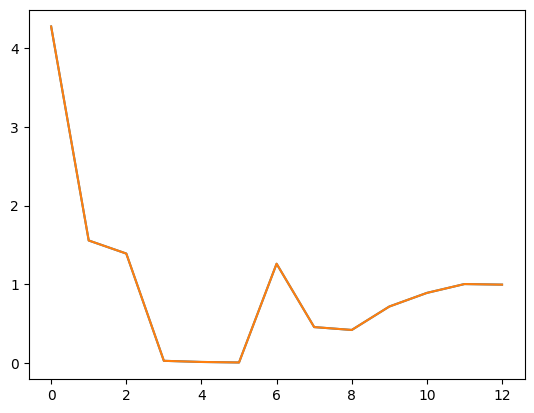

In [9]:
plt.plot(vals)
plt.plot(np.mean(shuffled_vals, axis=0))

In [45]:
data['date_id']

0            0
1            0
2            0
3            0
4            0
          ... 
5237975    480
5237976    480
5237977    480
5237978    480
5237979    480
Name: date_id, Length: 5237980, dtype: int64

In [53]:
data[stock_mask][quantitative_features].corr()

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
seconds_in_bucket,1.000000,-0.273937,-0.011644,-0.029766,0.337960,0.026583,0.043900,-0.010499,0.212719,-0.048914,0.239212,-0.029748,0.023285
imbalance_size,-0.273937,1.000000,-0.004491,-0.005352,0.060181,-0.127270,-0.180120,-0.013745,-0.069234,0.000115,-0.062584,-0.006281,-0.026299
imbalance_buy_sell_flag,-0.011644,-0.004491,1.000000,0.172032,-0.007151,0.366384,0.556970,0.138850,0.040516,0.138682,-0.054714,0.139324,0.017634
reference_price,-0.029766,-0.005352,0.172032,1.000000,-0.056667,0.225779,0.485529,0.995399,0.009750,0.995495,-0.025322,0.995669,-0.010609
matched_size,0.337960,0.060181,-0.007151,-0.056667,1.000000,0.001121,-0.032440,-0.055056,0.059343,-0.060060,0.075644,-0.058053,0.003643
far_price,0.026583,-0.127270,0.366384,0.225779,0.001121,1.000000,0.608313,0.220773,0.026797,0.218899,-0.027828,0.220856,0.033239
near_price,0.043900,-0.180120,0.556970,0.485529,-0.032440,0.608313,1.000000,0.479728,0.048880,0.477770,-0.047427,0.480446,0.097505
bid_price,-0.010499,-0.013745,0.138850,0.995399,-0.055056,0.220773,0.479728,1.000000,0.011648,0.994557,-0.017945,0.997209,-0.012585
bid_size,0.212719,-0.069234,0.040516,0.009750,0.059343,0.026797,0.048880,0.011648,1.000000,0.002823,0.103145,0.024678,-0.030808
ask_price,-0.048914,0.000115,0.138682,0.995495,-0.060060,0.218899,0.477770,0.994557,0.002823,1.000000,-0.027142,0.997166,-0.014479


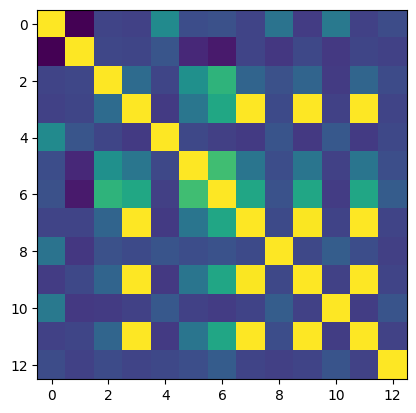

In [52]:
stock_id_of_interest = 4
stock_mask = data['stock_id']==stock_id_of_interest
plt.imshow(data[stock_mask][quantitative_features].corr())

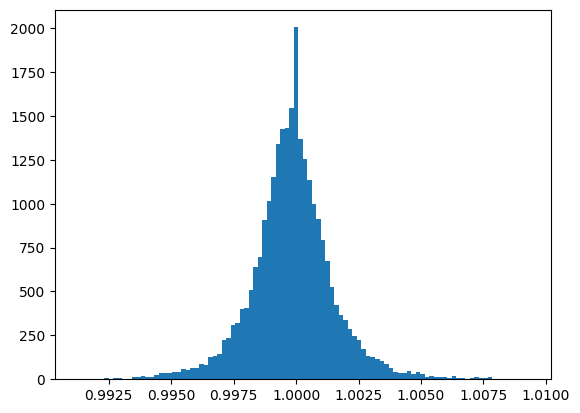

In [66]:
plt.hist(data[data['stock_id']==0]['wap'], bins=100)
plt.show()

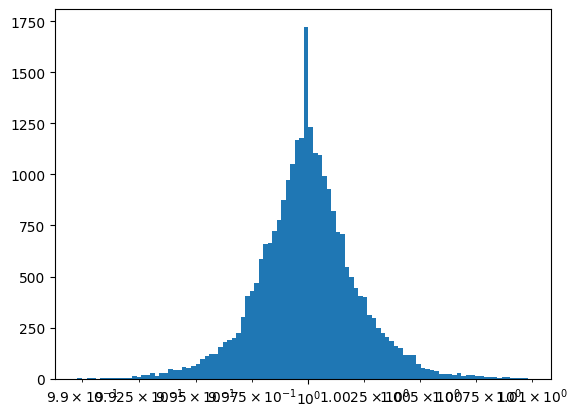

In [73]:
plt.hist(data[data['stock_id']==6]['wap'], bins=100)
plt.xscale('log')
plt.show()

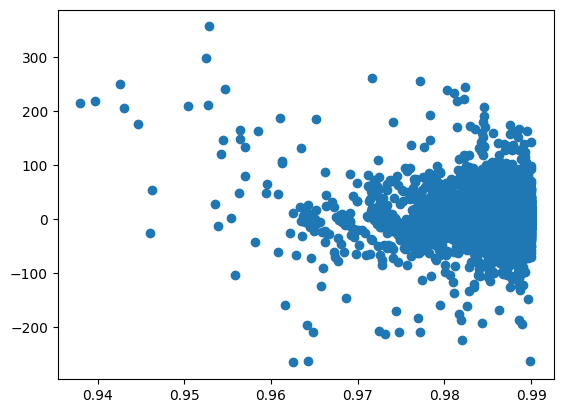

In [64]:
plt.scatter(data[data['wap']<0.99]['wap'], data[data['wap']<0.99]['target'])

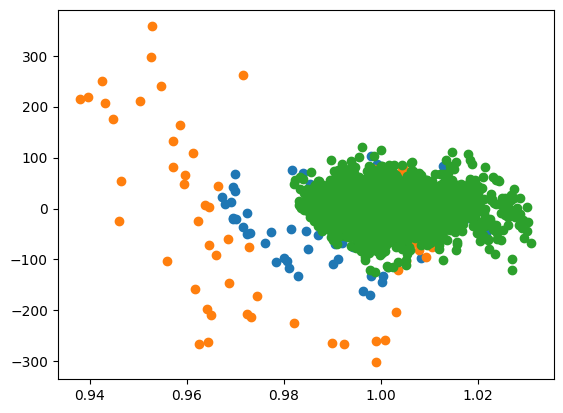

In [84]:
#plt.scatter(data[data['stock_id']==0]['wap'], data[data['stock_id']==0]['target'])
#plt.scatter(data[data['stock_id']==1]['wap'], data[data['stock_id']==1]['target'])
plt.scatter(data[data['stock_id']==2]['wap'], data[data['stock_id']==2]['target'])
#plt.scatter(data[data['stock_id']==3]['wap'], data[data['stock_id']==3]['target'])
#plt.scatter(data[data['stock_id']==4]['wap'], data[data['stock_id']==4]['target'])
plt.scatter(data[data['stock_id']==5]['wap'], data[data['stock_id']==5]['target'])
#plt.scatter(data[data['stock_id']==6]['wap'], data[data['stock_id']==6]['target'])
plt.scatter(data[data['stock_id']==11]['wap'], data[data['stock_id']==11]['target'])

plt.show()

In [96]:
stock_data = data.groupby('stock_id')['wap'].agg(['mean', 'std'])

In [98]:
merged_data = pd.merge(left=data, right=stock_data, how='outer', on='stock_id')

In [101]:
data[['wap','reference_price']].corr()

,wap,reference_price
wap,1.000000,0.988113
reference_price,0.988113,1.000000


In [102]:
merged_data['wap_rescaled'] = merged_data.apply(lambda row: (row['wap'] - row['mean'])/row['std'], axis=1)

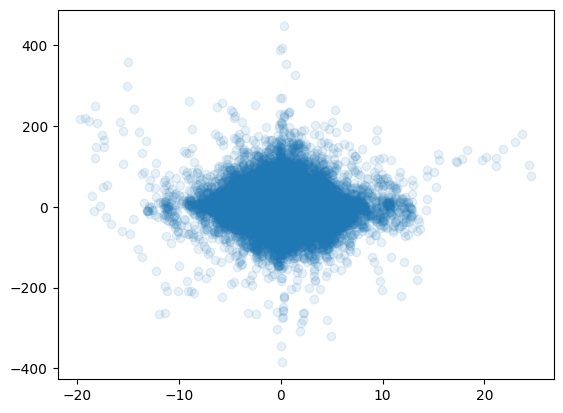

In [107]:
plt.scatter(merged_data['wap_rescaled'], merged_data['target'], alpha=0.1)

In [ ]:
from sklearn

In [62]:
data[(data['stock_id']==5) & (data['wap']<0.99)]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
911976,5,85,360,6166998.19,-1,0.989804,44337426.47,0.974639,0.976742,0.989804,221.26,0.990431,50036.40,0.989807,14.469624,4711,85_360_5
912172,5,85,370,6166998.19,-1,0.990028,44337426.47,0.974639,0.976742,0.989983,442.60,0.990565,244901.58,0.989984,18.550158,4712,85_370_5
914720,5,85,500,1112777.91,-1,0.989625,49391646.74,0.988373,0.988417,0.989625,5530.50,0.990207,265398.65,0.989637,-6.129742,4725,85_500_5
914916,5,85,510,1112777.91,-1,0.989088,49391646.74,0.988373,0.988417,0.988999,66545.08,0.989357,226025.52,0.989080,-1.720190,4726,85_510_5
915112,5,85,520,1112777.91,-1,0.989088,49391646.74,0.988373,0.988417,0.989044,133096.18,0.989357,514639.32,0.989108,-7.839799,4727,85_520_5
915308,5,85,530,1112777.91,-1,0.989446,49391646.74,0.988373,0.988954,0.989402,103286.39,0.989536,214121.60,0.989445,-11.940002,4728,85_530_5
915504,5,85,540,661899.44,-1,0.989044,49842525.22,0.988373,0.988417,0.988865,49073.10,0.989312,92440.70,0.989020,-15.749931,4729,85_540_5
1276494,5,119,170,765807.59,1,0.989478,18350415.84,NaN,NaN,0.988527,93575.00,0.990587,56262.00,0.989815,-263.389950,6562,119_170_5
1276691,5,119,180,3459102.70,1,0.978254,16682678.13,NaN,NaN,0.978280,21299.15,0.982664,3720.80,0.982015,-224.350100,6563,119_180_5
1276888,5,119,190,3467432.87,1,0.975428,16674347.96,NaN,NaN,0.974319,184.46,0.978175,18519.00,0.974357,-170.779830,6564,119_190_5


In [ ]:
plt

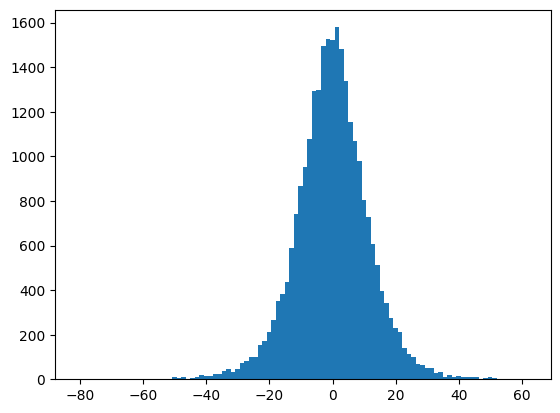

In [33]:
plt.hist(data[data['stock_id']==1]['target'], bins=100)
plt.show()

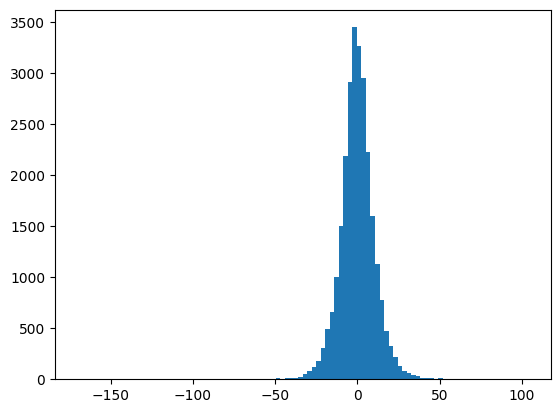

In [34]:
plt.hist(data[data['stock_id']==2]['target'], bins=100)
plt.show()

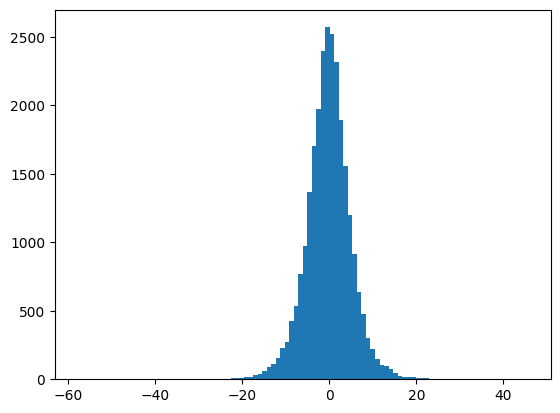

In [35]:
plt.hist(data[data['stock_id']==3]['target'], bins=100)
plt.show()

In [26]:
data.corr()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
stock_id,1.000000e+00,5.028770e-03,-1.116655e-16,0.024639,0.004067,-0.000752,0.035130,-0.000831,0.004736,0.004324,0.032975,-0.006342,0.027150,-0.000629,0.000130,0.005029,0.568940
date_id,5.028770e-03,1.000000e+00,1.280965e-14,0.006441,-0.010572,-0.006456,0.000525,-0.003004,-0.016150,-0.006528,0.024776,-0.006917,0.018673,-0.006839,0.000893,0.999998,0.446700
seconds_in_bucket,-1.116655e-16,1.280965e-14,1.000000e+00,-0.123946,-0.003635,-0.000835,0.068625,-0.000550,0.017627,0.014819,0.162867,-0.017826,0.146338,-0.001259,-0.002203,0.002083,0.218802
imbalance_size,2.463857e-02,6.441422e-03,-1.239456e-01,1.000000,-0.010159,-0.003717,0.512367,0.000523,-0.030932,0.005691,0.021141,-0.012774,0.022623,-0.003495,-0.001190,0.006183,-0.005419
imbalance_buy_sell_flag,4.066622e-03,-1.057243e-02,-3.634734e-03,-0.010159,1.000000,0.182100,-0.006003,0.018010,0.508853,0.129579,0.035238,0.132520,-0.013352,0.133823,0.015102,-0.010580,0.001548
reference_price,-7.519350e-04,-6.456302e-03,-8.347507e-04,-0.003717,0.182100,1.000000,0.007724,0.015349,0.473595,0.983646,0.007271,0.985068,-0.006528,0.988113,-0.017394,-0.006458,-0.006632
matched_size,3.513044e-02,5.254090e-04,6.862495e-02,0.512367,-0.006003,0.007724,1.000000,-0.000705,-0.002722,0.023564,0.078554,-0.007270,0.079209,0.008281,0.000197,0.000668,0.037265
far_price,-8.311000e-04,-3.004471e-03,-5.499413e-04,0.000523,0.018010,0.015349,-0.000705,1.000000,0.031519,0.014327,0.002229,0.014671,-0.000153,0.014643,-0.001804,-0.003005,-0.001236
near_price,4.736243e-03,-1.615006e-02,1.762744e-02,-0.030932,0.508853,0.473595,-0.002722,0.031519,1.000000,0.458373,0.032190,0.460380,-0.013298,0.462579,0.006045,-0.016133,-0.005470
bid_price,4.324366e-03,-6.528025e-03,1.481858e-02,0.005691,0.129579,0.983646,0.023564,0.014327,0.458373,1.000000,-0.001098,0.972906,-0.008456,0.989277,-0.022326,-0.006497,0.000849


In [11]:
mutual_infos = np.zeros((len(data.columns), len(data.columns)))

In [22]:
data['date_id'].dtype

dtype('int64')

In [23]:
for index_1, column_1 in enumerate(data.columns):
    for index_2, column_2 in enumerate(data.columns):
        if column_1!=column_2:
            candidate_data = data[[column_1, column_2]]
            candidate_data = candidate_data.dropna()
            mutual_infos[index_1, index_2] = sklearn.feature_selection.mutual_info_regression(np.asarray(candidate_data[column_1]).reshape(-1,1), candidate_data[column_2])

/var/folders/t5/hglcpfcd3px36gr5wgd_4mtm0000gn/T/ipykernel_1428/3653003503.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mutual_infos[index_1, index_2] = sklearn.feature_selection.mutual_info_regression(np.asarray(candidate_data[column_1]).reshape(-1,1), candidate_data[column_2])
/var/folders/t5/hglcpfcd3px36gr5wgd_4mtm0000gn/T/ipykernel_1428/3653003503.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mutual_infos[index_1, index_2] = sklearn.feature_selection.mutual_info_regression(np.asarray(candidate_data[column_1]).reshape(-1,1), candidate_data[column_2])
/var/folders/t5/hglcpfcd3px36gr5wgd_4mtm0000gn/T/ipykernel_1428/36530035

KeyboardInterrupt: 

In [24]:
mutual_infos

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.73422660e-01,
        2.38283244e-02, 5.24003949e-01, 2.45893466e+00, 1.94161347e+00,
        1.28732731e+00, 5.73854793e-01, 3.74308263e-01, 5.78202676e-01,
        3.70276610e-01, 5.03272393e-02, 5.17699878e-02, 0.00000000e+00,
        1.24459480e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.31543546e-01,
        3.48770527e-02, 8.89499340e-01, 2.40845800e+00, 2.49524697e+00,
        1.72546367e+00, 9.61989926e-01, 2.07488625e-01, 9.66457649e-01,
        2.04301929e-01, 2.15478890e-01, 1.79487437e-02, 6.17610955e+00,
        6.01609885e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.43054314e-02,
        2.00565531e-02, 5.68858110e-02, 1.45919063e-02, 6.68529382e-02,
        5.35190115e-02, 6.91845745e-02, 3.51401458e-02, 7.00156447e-02,
        3.61218517e-02, 1.42970756e-01, 1.60879492e-02, 4.00769746e+00,
        3.84524857e+00],
       [9.73023875e-01, 9.31387570e-01, 3.41027359e-02, 0.000

In [18]:
for column in data.columns:
    candidate = 

stock_id
date_id
seconds_in_bucket
imbalance_size
imbalance_buy_sell_flag
reference_price
matched_size
far_price
near_price
bid_price
bid_size
ask_price
ask_size
wap
target
time_id
row_id


In [16]:
sklearn.feature_selection.mutual_info_regression(data, data['target'])

ValueError: Input X contains NaN.